# Titanic: Machine learning from disaster using Logistic Regression


## Import  libraries

In [67]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

## The data

We start by reading the training data into a pandas DataFrame

In [68]:
train = pd.read_csv('data/titanic_train.csv')

In [69]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S




## Exploratory Data Analysis




The first plot is a heat map to see the proportion of data that is null. Later on, we have to decide how to deal with the null values.


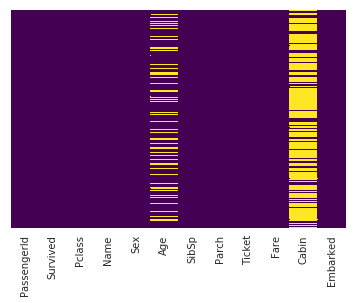

In [70]:
sns.heatmap(train.isnull(),yticklabels=False,cbar=False,cmap="viridis")

Roughly 20 percent of the Age data is missing. The proportion of Age missing is likely small enough for reasonable replacement with some form of imputation. Looking at the Cabin column, it looks like we are just missing too much of that data to do something useful with at a basic level. We'll probably drop this later, or change it to another feature like "Cabin Known: 1 or 0"

Next, a couple of more plots to have a better view of the data

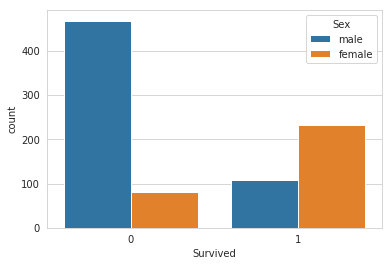

In [71]:
sns.set_style('whitegrid')
sns.countplot(x='Survived',data=train,hue='Sex')

Although there were more people deceased from the incident. However, for female passengers, their survival rate are much better, approximately 3:1.
Obviously, more female passengers survived, while the opposite is true for unfortunate male on the ship.





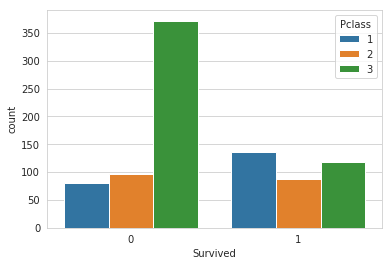

In [72]:
sns.countplot(x='Survived',data=train,hue="Pclass")

Here we can easily see the difference between the class of passenger's tickets.
The classes of the tickets are also indicator of social economic levels of the passengers.
Those who are from the upper class (Pclass = 1) are much more likely to survive that those from class 2 and 3.

Unfortunately, the probability of survival of those from class 3 is barely roughly 20%.

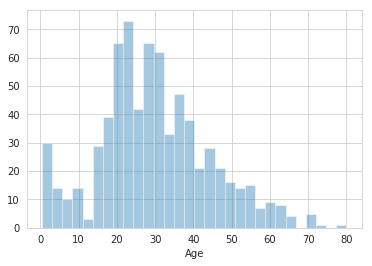

In [73]:
sns.distplot(train['Age'].dropna(),kde=False,bins=30)
# train['Age'].plot.hist(bins=30)

Most of the passengers on the ship were in their twenties and thirties.

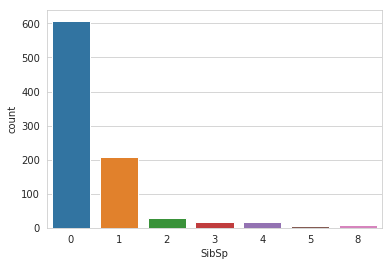

In [74]:
sns.countplot(train['SibSp'])

SibSp is the amount of Siblings/Spouse on the ship with a passenger.

Therefore, it is quite understandable that most of the passengers went on the ship by themselves. 
The second group is those who cruised with their wife/husband.
Only a small proportion of passengers were families.


Text(0.5, 0, 'Fare')

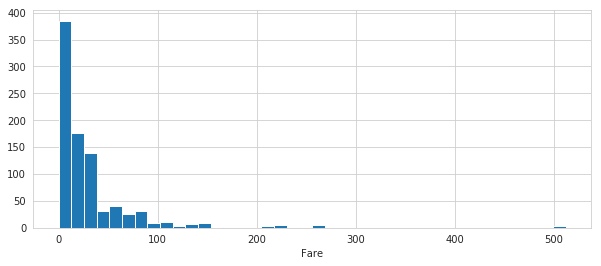

In [75]:
train['Fare'].hist(bins=40,figsize=(10,4))
# train['Fare'].plot(kind="hist",bins=40)
plt.xlabel('Fare')

The distribution of ticket prices is quite common.

Most of the passengers were from lower class, which conforms to earlier conclusion.

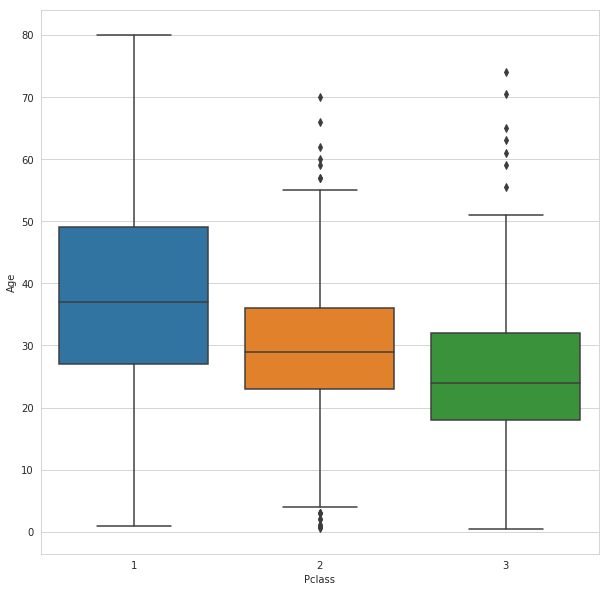

In [76]:
plt.figure(figsize=(10,10))
sns.boxplot(x='Pclass',y='Age',data=train)

Here, we can see the distribution of age of passengers from different classes.

It is quite reasonable that those from upper class has higher age in general. Those from the first class were typically 30 to 50 years old. While those from third class were only about 24 on average.

## Data Cleaning

We first take a look again at the null values in the data.

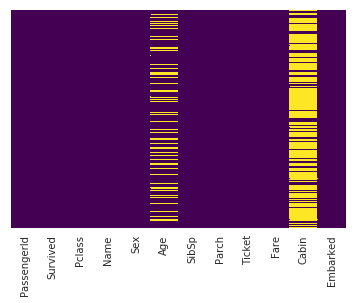

In [77]:
sns.heatmap(train.isnull(),yticklabels=False,cbar=False,cmap='viridis')

With the age column, only part of the data are missing. Maybe, it would be wise to fill in the null values with the mean of the age. However, there are couple of ways to determine the average. One primitive way is to fill in the overall average age. 
But as we see from an earlier graph, the age distribution also depends on the Pclass column. So we will impute  the average age of each Pclass into null values.

In [78]:
# impute mean of age based on Pclass into null in age column

def  impute_age(cols):
    Age = cols[0]
    Pclass = cols[1]
    
    if pd.isnull(Age):
        if Pclass == 1:
            return np.floor(np.mean(train['Age'][train['Pclass']==1].dropna()))
        elif Pclass == 2:
            return np.floor(np.mean(train['Age'][train['Pclass']==2].dropna()))
        else:
            return np.floor(np.mean(train['Age'][train['Pclass']==3].dropna()))
    else:    
        return Age


In [79]:

train['Age'] = train[['Age','Pclass']].apply(impute_age,axis=1)

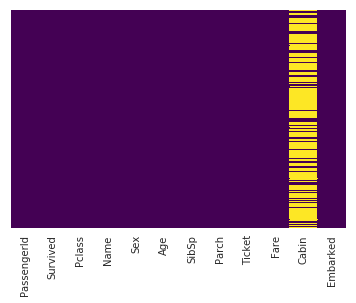

In [80]:
sns.heatmap(train.isnull(),yticklabels=False,cbar=False,cmap='viridis')

No more null values from age column.

For Cabin, most of the data is missing, so it may not worth trying to fill in the missing part. 

In [81]:
train.drop('Cabin',axis=1,inplace=True)

In [82]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S


In [83]:
train.dropna(inplace=True)

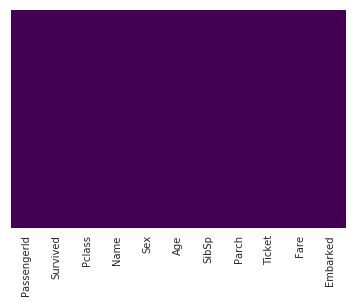

In [84]:
sns.heatmap(train.isnull(),yticklabels=False,cbar=False,cmap='viridis')

We have get rid of all the null values. And we will use this for the machine learning part.

## Converting Categorical Data

But there is still something to do with the data.
Sex and Embarked columns are categorical text data, which can't be fed into a machine learning algorithm.
We use pandas to directly make them usable.


In [85]:
sex = pd.get_dummies(train['Sex'],drop_first=True)

In [86]:
sex.head()

,male
0,1
1,0
2,0
3,0
4,1


In [87]:
embark = pd.get_dummies(train['Embarked'],drop_first=True)

In [88]:
embark.head()

,Q,S
0,0,1
1,0,0
2,0,1
3,0,1
4,0,1


In [89]:
train = pd.concat([train,sex,embark],axis=1)

In [90]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,male,Q,S
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,1,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,0,0,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,0,0,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S,0,0,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S,1,0,1


In [91]:
train.drop(['Embarked','Ticket','Sex','Name','PassengerId'],axis=1,inplace=True)

We drop those columns which can't be fed into a machine learning algorithm.

And we have the final training dataset.

In [92]:
train.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,male,Q,S
0,0,3,22.0,1,0,7.2500,1,0,1
1,1,1,38.0,1,0,71.2833,0,0,0
2,1,3,26.0,0,0,7.9250,0,0,1
3,1,1,35.0,1,0,53.1000,0,0,1
4,0,3,35.0,0,0,8.0500,1,0,1


In [115]:
X = train.drop('Survived',axis=1)
y = train['Survived']

## Build a Logistic Regression model

## Train Test split

In [97]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [116]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=101)

## The model, fit and predict

In [ ]:
logmodel = LogisticRegression(solver='lbfgs')

In [109]:
logmodel.fit(X_train,y_train)

/home/hung/miniconda2/envs/yunnnn3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning:

lbfgs failed to converge. Increase the number of iterations.



LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

In [110]:
predictions = logmodel.predict(X_test)

## Performance Evaluation

In [111]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

In [112]:
print(accuracy_score(y_test,predictions))

0.8314606741573034


In [113]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.83      0.91      0.87       163
           1       0.84      0.70      0.76       104

   micro avg       0.83      0.83      0.83       267
   macro avg       0.83      0.81      0.82       267
weighted avg       0.83      0.83      0.83       267



In [114]:
confusion_matrix(y_test,predictions)

array([[149,  14],
       [ 31,  73]])

**With a simple model of Logistic Regression and some straightfoward features from the data, we obtain a cross_validation accuracy score of 0.831...**
